# Лекция 11. Расширенное управление процессами

1. Права пользователей при запуске процессов
2. Приоритеты процессов
3. Сигналы

## 1. Права пользователей при запуске процессов

Для регулирования прав доступа к различным объектам в Linux используются понятия **пользователь, группа пользователя**. Все запускаемые программы (процессы) также выполняются от имени какого-то пользователя, группы пользователя и имеют соответствующие права доступа.

Для задания пользователя и группы используются числовые значения (**идентификаторы UID, GID**), а также текстовые обозначения (названия). Например, числовой идентификатор пользователя **root** равен 0. Внутри себя система работает только с числовыми идентификаторами.

Соответствие названий пользователей и групп их числовым идентификаторам прописано в файлах **/etc/passwd, /etc/group**. 

В качестве примера приведен скриншот содержимого файла **passwd**:

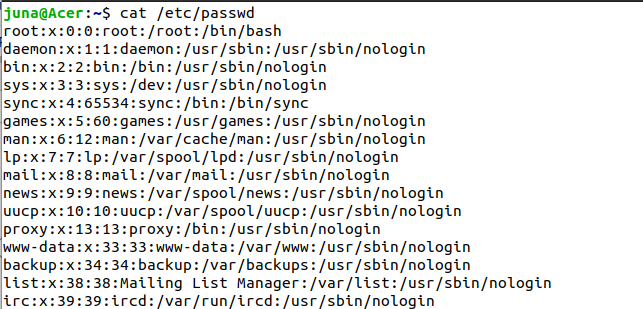

Здесь каждая строка соответствует определенному пользователю. Например,:

|**root**:|x:|0:|0:|**root**:|**/root**:|/bin/bash|
|---------|--|--|--|---------|----------|---------|
|Имя пользователя|Пароль|UID|GID|Настоящее имя пользователя|Домашний каталог|Командная оболочка|

Пример содержимого файла **group** представлен ниже:

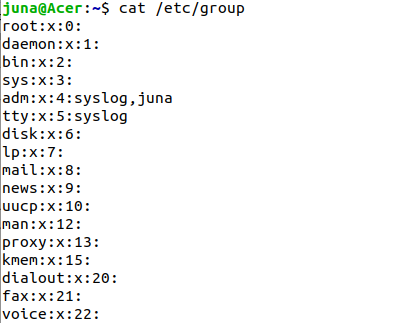



|**adm**:|x:|4:|syslog, juna|
|--------|--|--|------------|
|Имя группы|Пароль|GID|Пользователь, включенные в эту и другие группы|

В современных системах Linux пароль в файлах **passwd, group** не хранится, а применяются так называемые теневые файлы
паролей – **shadow и gshаdow**. Доступ к ним имеет только пользователь **root**, вместо паролей хранятся хэши паролей.

Вот так выглядит, например, **shadow**:

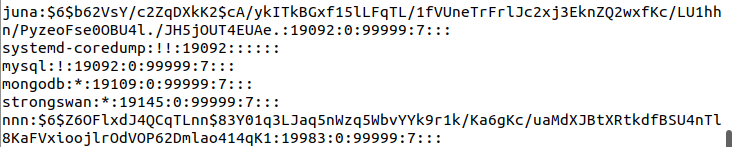



После хэша пароля идет следующая последовательность чисел (возможно с пропусками):
- число дней последнего изменения пароля, начиная с 1 января 1970 года;
- число дней, перед тем как пароль может быть изменён;
- число дней, после которых пароль должен быть изменён;
- число дней, за сколько пользователя начнут предупреждать, что пароль устаревает;
- число дней, после устаревания пароля для блокировки учётной записи;
- число дней, отсчитывая с 1 января 1970 года, когда учётная запись будет заблокирована.

В системе Linux существуют четыре разновидности идентификаторов пользователей и групп: **реальные, эффективные (действительные), сохраненные, идентификаторы файловой системы**. 

**Реальный идентификатор пользователя (UID)** — это uid пользователя, который изначально запустил (создал) процесс. Он устанавливается по реальному идентификатору пользователя родительского процесса и не изменяется в течение работы вызова exec. Обычно при авторизации устанавливается реальный идентификатор пользователя, и все процессы пользователя продолжают работу с этим идентификатором.

**Эффективный идентификатор пользователя (EUID)** — это идентификатор, под которым в настоящий момент выполняется процесс. Проверка доступа обычно основывается на этом значении. Изначально этот идентификатор равен реальному идентификатору пользователя, поскольку, когда процесс начинает ветвление (fork), эффективный идентификатор пользователя передается от родительского процесса к дочернему. Далее, когда процесс сталкивается с вызовом exec, он может изменить свой эффективный пользовательский идентификатор. 

Точнее, **эффективный идентификатор пользователя меняется на идентификатор пользователя, который является владельцем вызываемой программы**.

**Сохраненный идентификатор пользователя (SUID)**  - это сохраненная версия EUID, которую можно вернуть во время выполнения программы. Это позволяет программе временно потерять привилегии, а затем восстановить их.

### Изменение реального или сохраненного идентификатора пользователя или группы

Идентификаторы пользователя или группы устанавливаются с помощью двух системных вызовов:

In [ ]:
#include <sys/types.h>
#include <unistd.h>
int setuid (uid_t uid);
int setgid (gid_t gid);

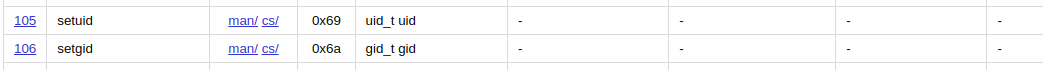

Вызов **setuid()** устанавливает эффективный идентификатор пользователя текущего процесса. Если текущий эффективный идентификатор пользователя данного процесса равен 0 (root), устанавливаются также реальный и сохраненный идентификаторы. 

Пользователь root сможет передавать в качестве параметра uid любые значения, устанавливая всем трем значениям пользовательского идентификатора величину uid. 

Пользователь без прав root может изменять только величину реального или сохраненного пользовательского идентификатора. Другими словами, пользователь без прав root может установить эффективному идентификатору пользователя лишь одно из этих значений.
В случае успеха **setuid()** возвращает 0. При ошибке вызов возвращает -1, а errno присваивает код ошибки.

Ниже представлена программа, демонстрирующая использование **setuid**.

In [ ]:
	;; get_set_uid.asm
	
	format elf64

	public _start

	extrn printf
	extrn getchar

	include "func.asm"

	section '.data' writable
	
	getuid db "uid: %jd", 0xa, 0
	geteuid db "euid: %jd", 0xa, 0
	msg_1 db "change uid = %d", 0xa, 0

	section '.text' executable
	
_start:
	;; Получаем и печатаем uid
	mov rax, 102
	syscall
	mov rdi, getuid
	mov rsi, rax
	call printf

	;; Получаем и печатаем euid
	mov rax, 107
	syscall
	mov rdi, geteuid
	mov rsi, rax
	call printf

	mov rsi, [rsp+16]
	call str_number
	mov rsi, rax
	mov r12, rax
	mov rdi, msg_1
	call printf
	
	
	
	;; Изменяем uid
	mov rdi, r12
	mov rax, 105
	syscall

	
	;; Получаем и печатаем uid
	mov rax, 102
	syscall
	mov rdi, getuid
	mov rsi, rax
	call printf

	;; Получаем и печатаем euid
	mov rax, 107
	syscall
	mov rdi, geteuid
	mov rsi, rax
	call printf

	
	;; Ожидаем ввода любого символа и заканчиваем работу
	call getchar
	call exit

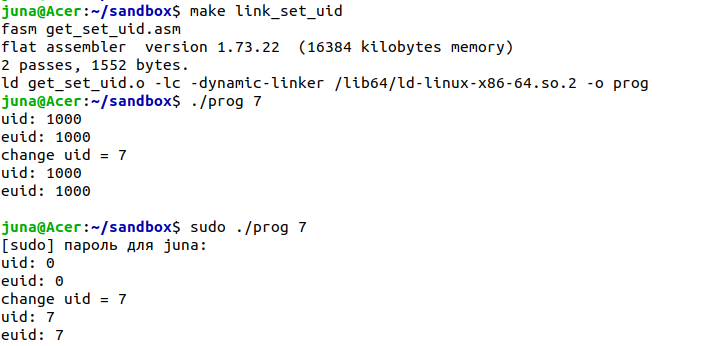

В программе параметром скрипта задается идентификатор пользователя. Программа меняет идентификатор пользователя, от имени которого запускается данный процесс на заданный параметром скрипта. Видно, что без прав суперпользователя изменить права не удается.

Аналогично ниже представлена программа, демонстрирующая изменение прав группы пользователя.

In [ ]:
	;; get_set_gid.asm
	
	format elf64

	public _start

	extrn printf
	extrn getchar

	include "func.asm"

	section '.data' writable
	
	getgid db "gid: %jd", 0xa, 0
	getegid db "egid: %jd", 0xa, 0
	msg db "change gid = %d", 0xa, 0

	section '.text' executable
	
_start:
	;; Получаем и печатаем gid
	mov rax, 104
	syscall
	mov rdi, getgid
	mov rsi, rax
	call printf

	;; Получаем и печатаем egid
	mov rax, 108
	syscall
	mov rdi, getegid
	mov rsi, rax
	call printf
	
	mov rsi, [rsp+16]
	call str_number
	mov rsi, rax
	mov r12, rax
	mov rdi, msg
	call printf
	
	;; Изменяем gid
	mov rax, 106
	mov rdi, r12
	syscall

	;; Получаем и печатаем gid
	mov rax, 104
	syscall
	mov rdi, getgid
	mov rsi, rax
	call printf

	;; Получаем и печатаем egid
	mov rax, 108
	syscall
	mov rdi, getegid
	mov rsi, rax
	call printf
	
	;; Ожидаем ввода любого символа и заканчиваем работу
	call getchar
	call exit

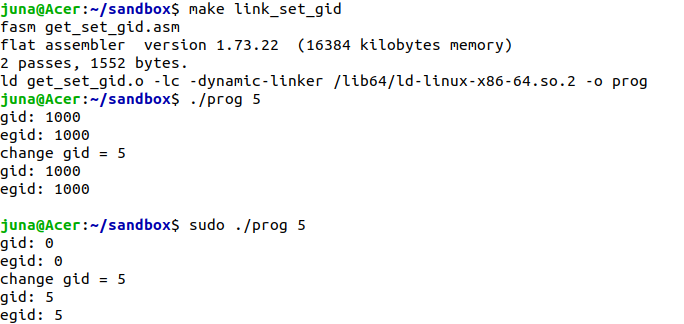

Кроме перечисленных прав, у каждого файла есть еще один набор прав доступа – биты **SUID и SGID**, а также **Sticky_bit**. 

Биты **SUID, SGID** позволяют при запуске программы присвоить ей эффективные идентификаторы владельца и группы-владельца соответственно и выполнять процесс с правами доступа другого пользователя.

**SUID** – это бит разрешения, который позволяет пользователю запускать исполняемый файл с правами владельца этого файла. Другими словами, использование этого бита позволяет нам поднять привилегии пользователя в случае, если это необходимо.

Если на месте x (исполнение) выставлен специальный бит s, то это как раз означает, что установлены **SUID, SGID**, что позволяет пользователю системы выполнять команды с повышенными привилегиями без необходимости входа в систему как root.

**Sticky Bit** -  запрещает удаление файла всем, кроме его владельца и суперпользователя. Другие пользователи системы, даже если они входят в группу владельца, удалить файл не смогут. Если бит установить на каталог — аналогичные правила будут распространяться на все его содержимое: файлы в этом каталоге могут быть удалены только их владельцем. Пример использования этого бита в операционной системе это системная папка /tmp . Эта папка разрешена на запись любому пользователю, но удалять файлы в ней могут только пользователи, являющиеся владельцами этих файлов. 

Устанавливаются биты SGID и SUID программой chmod:

> **chmod u+s filename – установка бита SUID**

> **chmod g+s filename – установка бита SGID**

> **chmod a+t filename – установка бита Sticky Bit**

Для установки этих битов в абсолютном режиме их стоить представить в виде трех бит: **SUID, SGID, Sticky_bit** соответственно:

|**SUID**|**SGID**|**Sticky_bit**|**Decimal**|
|--------|--------|--------------|-----------|
|   0    |    0   |      0       |     0     |
|   0    |    0   |      1       |     1     |
|   0    |    1   |      0       |     2     |
|   0    |    1   |      1       |     3     |
|   1    |    0   |      0       |     4     |
|   1    |    0   |      1       |     5     |
|   1    |    1   |      0       |     6     |
|   1    |    1   |      1       |     7     |


Например, 
> **chmod 7777 filename**

В качестве примера рассмотрим использование бита **SUID**.

Для этого возьмем разработанную ранее программу, которая меняет права владельца процесса. На скриншоте видно, что заставить программу изменить права можно только если ее запустить от имени root:

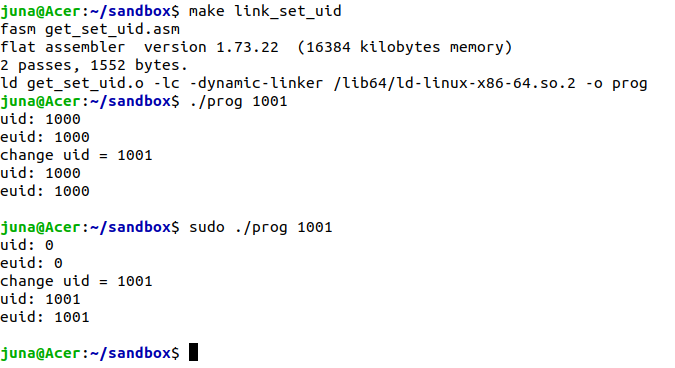

Попробуем теперь поменять владельца исполняемого файла ./prog на пользователя root (в качестве справки, изменить группу владельца можно с помощью команды **chgrp**):

> sudo chown root ./prog

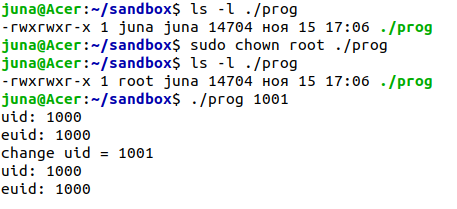

Как видно, изменение владельца файла и запуск его от имени пользователя juna не позволяет менять назначение прав.

Попробуем теперь установить бит **SUID**:

> sudo chmod u+s ./prog

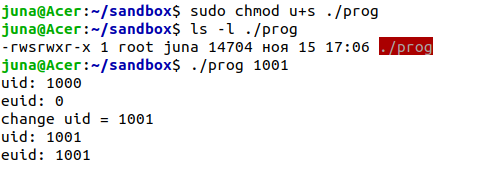

Из скриншота мы видим, что запуск этого файла обычным пользователем позволяет получить эффективный идентификатор пользователя root и получить желаемый результат.

На последнем скриншоте показано, что установка sticky bit на файл не позволяет его удалить другим пользователям, кроме владельца.

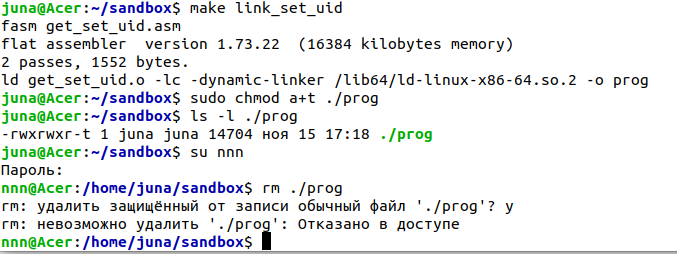

Также в архитектуре **x86-64** существуют сиcтемные вызовы, пришедшие от разработчиков BSD:

In [ ]:
#include <sys/types.h>
#include <unistd.h>
int setreuid (uid_t ruid, uid_t euid);
int setregid (gid_t rgid, gid_t egid);

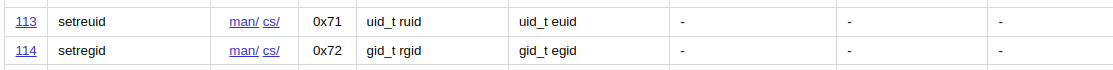

Вызов **setreuid()** устанавливает реальные и эффективные идентификаторы процесса равными **ruid** и **euid** соответственно. 

Передача величины -1 для любого из параметров не изменит соответствующий идентификатор пользователя. 

Процессы без прав root могут только устанавливать значение эффективного  идентификатора пользователя равным реальному или сохраненному идентификатору, а реального — эффективному. Если реальный пользовательский идентификатор изменился или эффективный пользовательский идентификатор изменился, став величиной, не равной предыдущему реальному идентификатору, сохраненный идентификатор пользователя изменяется на новый эффективный  идентификатор. 

В случае успеха setreuid() возвращает 0. При неудаче возвращает -1 и присваивает errno значение EPERM.



## 2. Приоритеты процессов

**Планировщик процессов**  - это компонент ядра, обеспечивающий выбор процесса, который будет выполняться следующим.

Принимая решение, какие процессы могут быть запущены и когда, планировщик отвечает за максимизацию использования процессора одновременно с обеспечением видимости, что несколько процессов выполняются одновременно, не мешая друг другу.

Операционная система на машине с одним процессором является **многозадачной**, если она способна чередовать выполнение нескольких процессов, создавая видимость, что в каждый момент времени работает более одного процесса.  

В компьютерах с несколькими процессорами многозадачная операционная система обеспечивает параллельную работу процессов в действительности, на разных процессорах. Немногозадачная операционная система, например DOS, в каждый момент времени может
запускать только одно приложение.

Многозадачные операционные системы бывают двух видов — **кооперативные и приоритетные**. 

Linux является приоритетной, это означает, что планировщик решает, когда прекратить выполнение одного процесса и возобновить
другой. 

Действие по приостановке одного процесса для возобновления другого называется **переключением**. Время, в течение которого процесс может выполняться, прежде чем планировщик его прервет, известно как **квант времени процесса**.

При кооперативном типе многозадачности, напротив, процесс не останавливается, пока самостоятельно не примет решение сделать это. 

Добровольное прерывание выполнения процесса им самим называется **уступкой**. В идеальном случае процессы должны уступать, а операционная система не может влиять на их поведение. 

Однако плохо написанная или поврежденная программа может выполняться достаточно долго, чтобы нарушить видимость многозадачности. 

Из-за этого существенного недостатка большинство операционных систем предпочитают приоритетный вид многозадачности.

Планировщик, доступный, начиная с версии ядра Linux 2.6.23, называется **CFS (Completely Fair Scheduler)**. Название происходит от внедрения в планировщик принципа равноправной очереди, планирующего алгоритма, который старается обеспечить равный доступ к ресурсам всем конкурирующим потребителям. 

Квант времени, который планировщик выделяет каждому процессу, является очень важной величиной с точки зрения общего поведения и производительности системы. Если квант слишком велик, процессы должны ждать долгое время между периодами выполнения, минимизируя видимость одновременной работы. И наоборот, если квант времени слишком мал, значительная доля системного времени тратится на переключение между разными приложениями, из-за чего выгода приоритетности пропадают.

**Вместо квантов времени CFS назначает каждому процессу долю процессорного времени**. 

CFS запускается, назначая N процессам каждому по 1/N времени процессора. Затем эти доли уточняются, «взвешивая» каждый процесс по его точной величине. Процессы с нулевой точной величиной по умолчанию имеют вес, равный единице, следовательно, их пропорция не меняется. Процессы с меньшей точной величиной (высший приоритет) получают больший вес, увеличивая свою долю ресурсов процессора, в то время как процессы с большей точной величиной (низший приоритет) получают меньший вес, уменьшая свой расход ресурсов процессора.

Таким образом CFS получает взвешенную пропорцию времени процессора, назначенную каждому процессу. Чтобы определить точное время выполнения каждого процесса, CFS требуется поделить эти пропорции на фиксированные периоды. Такой период называется **целевой задержкой**, так как он представляет собой запланированную задержку в работе системы. 

Целевая задержка должна рассчитываться не только с учетом приоритета процессов, но и суммарного количества процессов. Поскольку при достаточно большом количестве процессов большая доля времени будет уходить на переключение от одного процесса к другому, известных как **задержки переключения**, что существенно снизит общую пропускную способность системы. 

Чтобы разрешить эту ситуацию, CFS представляет другой ключевой фактор — минимальную детализацию.

**Минимальная детализация** — нижний предел длины промежутка времени для запуска любого процесса. Все процессы, независимо от полученной ими доли ресурсов процессора, будут запускаться самое меньшее на величину промежутка минимальной детализации (или пока не заблокируются). Это позволяет убедиться, что задержки переключения не занимают неприемлемо большой доли системного времени за счет сохранения величины целевой задержки. 

Таким образом, с помощью минимальной детализации и обеспечивается беспристрастность. С обычными величинами целевой задержки и минимальной детализации при разумном количестве запущенных процессов минимальная детализация не требуется, ибо беспристрастность и величина целевой задержки достигаются и так.


Хотя Linux — многозадачная операционная система приоритетного типа, в ней имеется системный вызов, позволяющий принудительно прервать выполнение процессов и заставить планировщик выбрать новый процесс для исполнения:


In [ ]:
#include<sched.h>
int sched_yield(void);

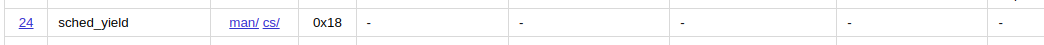


Вызов **sched_yield()** приведет к остановке выполняющегося в настоящее время процесса, после чего планировщик выбирает новый процесс для запуска таким же образом, как если бы ядро само прекратило выполняющийся процесс и запустило
новый. 

Необходимо отметить, что, если нет других выполняющихся процессов, как часто и бывает, прерванный процесс будет тут же запущен снова. Из-за этой неопределенности в сочетании с общим принципом, что всегда есть лучший выбор, данный системный вызов используется нечасто.

В случае успеха вызов возвращает 0; при неудаче -1 и отправляет errno в соответствующем коде ошибки. В

На практике существует не так много вариантов правомерного использования **sched_yield()** в действительно многозадачной системе с вытеснением наподобие Linux. Ядро отлично справляется с принятием оптимальных и наиболее выгодных решений по планированию самостоятельно — действительно, ведь ядро лучше, чем отдельное приложение, подготовлено к задачам
очередности вытеснения. Вот почему разработчики операционных систем отказываются от кооперативной многозадачности в пользу вытесняющей.

Почему же тогда в POSIX вообще существует такой системный вызов, как «переделка расписания»? Ответ заключен в приложениях, которым приходится ожидать событий вовне, которые могут быть вызваны действиями пользователя, аппаратного обеспечения или другими событиями. В частности, если один процесс должен ожидать другого, самое простое решение — «просто уступи ресурсы
процессора, пока другой процесс не завершится».  Еще один пример использования **sched_yield()** — «любезная игра»: программы,
сильно нагружающие процессор, периодически могут вызывать **sched_yield()**, пытаясь минимизировать свое воздействие на систему. 

Эти благие намерения имеют, однако, два недостатка. Во-первых, ядро способно скорее принимать стратегические
решения о планировании, чем обрабатывать отдельные процессы, и, следовательно, нести ответственность за корректную работу системы должен скорее планировщик, а не процесс. Во-вторых, уменьшение нагрузки, создаваемой приложениями, и предоставление другим приложениям доступа к ресурсам процессора — это ответственность пользователя, а не самих приложений. Пользователь может формулировать свои представления о приоритетах производительности приложения с помощью команды оболочки nice.


Основная идея — «быть любезными» по отношению к другим процессам путем следования процессной приоритетности, позволяя другим процессам потреблять больше системного процессорного времени.

Пределы значений **любезности** — от –20 до 20 включительно, а значение по умолчанию — 0. Может быть не совсем понятно, почему чем ниже значение любезности процесса, тем выше его приоритет и больше квант времени. Увеличение значения любезности процесса «оказывает любезность» остальной части системы.

Linux предоставляет несколько вызовов для получения и установки значения любезности процесса. 

**Приоритеты процессов**

Предпочтительным решением является применение системных вызовов **getpriority() и setpriority()**, которые предоставляют больше возможностей для управления и контроля, но сложнее в использовании:

In [ ]:
#include <sys/time.h>
#include <sys/resource.h>
int getpriority (int which, int who);
int setpriority (int which, int who, int prio);

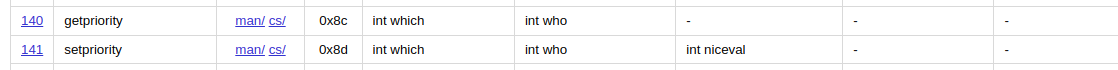

Эти вызовы воздействуют на процесс, группу процессов или пользователей, что определено с помощью **which и who**. 

Значение **which** должно быть **PRIO_PROCESS, PRIO_PGRP или PRIO_USER**, в то время как **who** указывает идентификатор процесса, группы процессов или идентификатор пользователя соответственно. 

Если значение who равно 0, то вызов работает с текущими идентификатором процесса, группы процессов или идентификатором пользователя соответственно.

Вызов getpriority() возвращает наибольший приоритет (наименьшую численную величину значения любезности) каждого из указанных процессов. 

Вызов setpriority() устанавливает значение приоритета каждого из указанных процессов, равное prio. Как и nice(), только процесс со свойством CAP_SYS_NICE может увеличить приоритет процесса (снизить численное значение любезности). Следовательно, только процесс с этим свойством может увеличить или уменьшить приоритет процесса, не принадлежащего вызывающему пользователю.

Как и nice(), getpriority() возвращает -1 в случае ошибки. Это может быть и возвращенный результат при успешном срабатывании, поэтому программист должен очистить errno перед вызовом, если нужно обработать условия ошибки.

Вызов setpriority() не приводит к таким проблемам, он всегда возвращает 0 в случае успеха и -1 в случае ошибки.

Соответствие числовых значений можно увидеть в файле /usr/include/linux/resource.h

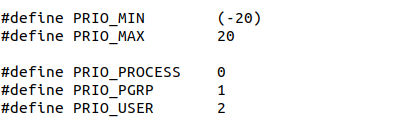

Ниже представлена программа, демонстрирующая использование системных вызовов изменения приоритетов.

In [ ]:
	;; get_set_priory.asm
	
	format elf64

	public _start

	extrn printf
	extrn getchar

	include "func.asm"

	section '.data' writable
	
	getprocess db "process_priory: %jd", 0xa, 0
	
	getpgrp db "pgrp_priory: %jd", 0xa, 0
	
	getuser db "user_priory: %jd", 0xa, 0

	msg db "change priory", 0xa, 0
	
	msg_2 db "Error set priory", 0xa, 0

	section '.text' executable
	
_start:
	;; Получаем priory_progress
	mov rax, 140
	mov rdi, 0
	mov rsi,0
	syscall
	mov rdi, getprocess
	mov rsi, rax
	call printf
	
	;; Получаем priory_pgrp
	mov rax, 140
	mov rdi, 1
	mov rsi,0
	syscall
	mov rdi, getpgrp
	mov rsi, rax
	call printf
	
	;; Получаем priory_user
	mov rax, 140
	mov rdi, 2
	mov rsi,0
	syscall
	mov rdi, getuser
	mov rsi, rax
	call printf
	
	call new_line
	
	mov rdi, msg
	call printf
	
	call new_line
	
	;; Устанавливаем priory_process
	mov rax, 141
	mov rdi, 0
	mov rsi,0
	mov rdx, 8
	syscall
	cmp rax, 0
	je pp_1
	mov rdi, msg_2
	call printf
	pp_1:
	
	;; Получаем priory
	mov rax, 140
	mov rdi, 0
	mov rsi,0
	syscall
	mov rdi, getprocess
	mov rsi, rax
	call printf
	
	;; Устанавливаем priory_pgrp
	mov rax, 141
	mov rdi, 1
	mov rsi,0
	mov rdx, 12
	syscall
	cmp rax, 0
	je pp_2
	mov rdi, msg_2
	call printf
	pp_2:
	
	;; Получаем priory
	mov rax, 140
	mov rdi, 1
	mov rsi,0
	syscall
	mov rdi, getpgrp
	mov rsi, rax
	call printf
	
	;; Устанавливаем priory_user
	mov rax, 141
	mov rdi, 2
	mov rsi,0
	mov rdx, 10
	syscall
	cmp rax, 0
	je pp_3
	mov rdi, msg_2
	call printf
	pp_3:
	
	;; Получаем priory_user
	mov rax, 140
	mov rdi, 2
	mov rsi,0
	syscall
	mov rdi, getuser
	mov rsi, rax
	call printf

	;; Ожидаем ввода любого символа и заканчиваем работу
	call getchar
	call exit

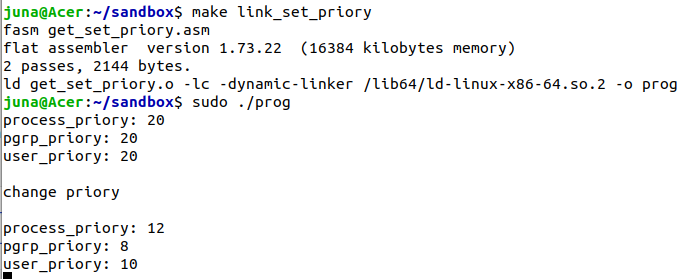

Из представленного скриншота видно, что значение любезности текущего процесса максимально (т.е. оно имеет наименьший приоритет), также видно, что значение **niceval** вычитается из текущего приоритета.


**Приоритеты ввода-вывода**


В дополнение к приоритетам планирования Linux позволяет процессам указывать приоритеты ввода-вывода. Эти значения влияют на относительные приоритеты запросов ввода-вывода процессов. Планировщик ядра, ответственный за ввод-вывод, обслуживает запросы, поступающие от процессов, по мере снижения приоритетов ввода-вывода последних.

По умолчанию планировщики ввода-вывода используют значение любезности процесса для определения приоритетов ввода-вывода. 

Следовательно, установка значения любезности автоматически меняет приоритет ввода-вывода. Однако ядро
Linux дополнительно предоставляет два системных вызова для экстренной установки и получения приоритетов ввода-вывода независимо от значения любезности:


In [ ]:
int ioprio_get (int which, int who)
int ioprio_set (int which, int who, int ioprio)

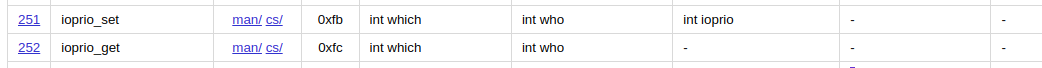

Кстати, следует заметить, что  glibc не предоставляет в пользовательском пространстве интерфейсов для этих системных вызовов. 

Не все планировщики ввода-вывода поддерживают приоритеты ввода-вывода.
Планировщик Completely Fair Queuing (CFQ) поддерживает их; другие планировщики — в настоящее время нет. Если имеющийся планировщик ввода-вывода не поддерживает приоритеты ввода-вывода, они игнорируются без каких-либо предупреждений.

## 3. Сигналы

**Сигналы** - это программные прерывания, обеспечивающие асинхронную обработку событий. 

Эти события могут приходить из-за пределов системы; например, пользователь может сгенерировать символ прерывания, нажав Ctrl+C. Другие источники прерываний - действия программы или ядра; например, сигнал возникнет, если процесс выполнит код, в котором происходит деление на нуль. 

В качестве примитивной формы межпроцессной коммуникации (IPC) один процесс также может послать сигнал другому процессу.

Основная черта сигналов заключается в том, что не только события происходят асинхронно - например, пользователь может нажать Ctrl+C в любой момент работы программы, - но и обработка сигналов в программе выполняется асинхронно.

Функции обработки сигналов регистрируются в ядре, которое асинхронно вызывает функции из остальной части программы, когда программа получает тот или иной сигнал.

Сначала сигнал генерируется. Затем ядро сохраняет сигнал до тех пор, пока не сможет его доставить. Наконец, как только появляется
такая возможность, ядро обрабатывает сигнал требуемым образом. 

В зависимости от требований процесса ядро может выполнить одно из трех действий:
- Игнорировать сигнал. Никаких действий не предпринимается. Есть два сигнала, которые не могут быть проигнорированы: **SIGKILL и SIGSTOP**. Дело в том, что системный администратор должен иметь возможность останавливать или завершать (убивать) процессы. Если бы процесс был способен проигнорировать SIGKILL (стать «бессмертным») или SIGSTOP (стать «неудержимым»), то системный администратор лишился бы такой возможности.
- Перехватить сигнал и обработать его. Ядро приостанавливает исполнение текущего кода в процессе и переключается на функцию, которая была зарегистрирована ранее. Затем процесс выполняет эту функцию. Когда он вернется после ее выполнения, процесс вновь перейдет к выполнению той работы, которую прервал в момент получения сигнала. Особенно часто приходится отлавливать сигналы SIGINT и SIGTERM. Процессы отлавливают SIGINT, реагируя на действие пользователя, сгенерировавшего символ прерывания. Например, терминал может перехватить этот сигнал и вернуться в основное окно с приглашением. Процессы отлавливают SIGTERM для выполнения необходимой очистки, например для отсоединения от сети или для удаления временных файлов — до завершения. Сигналы SIGKILL и SIGSTOP нельзя перехватить.
- Выполнение действия, задаваемого по умолчанию. Это действие зависит от того, какой именно сигнал был отправлен. Зачастую стандартное действие — это завершение процесса. Например, именно так обрабатывается сигнал SIGKILL. Тем не менее многие сигналы предоставляются для строго определенной цели и интересуют программиста лишь в конкретной ситуации. Поэтому по умолчанию подобные сигналы игнорируются, так как большинство программ в них «не заинтересованы». Ниже мы рассмотрим различные сигналы и стандартные действия, выполняемые по умолчанию при их получении.


У каждого сигнала есть символьное имя, начинающееся с префикса SIG.

Все сигналы описываются в заголовочном файле, включаемом из **<signal.h>**.

Также каждый сигнал ассоциирован с целочисленным идентификатором. 

У сигналов отображение имени на целое число зависит от реализации и отличается в разных системах UNIX. 

Около десятка наиболее распространенных сигналов везде отображаются одинаково (например, SIGKILL — это печально известный сигнал 9). 

В таблице перечислены сигналы, поддерживаемые в Linux.

|Сигнал| Описание |Действие по умолчанию|
|------|----------|---------------------|
|SIGABRT| Отправляется функцией abort()| Завершение с дампом ядра|
|SIGALRM| Отправляется функцией alarm()| Завершение|
|SIGBUS| Аппаратная ошибка или ошибка выравнивания| Завершение с дампом ядра|
|SIGCHLD| Дочерний процесс был завершен| Игнорируется|
|SIGCONT| Процесс продолжил работу и был остановлен| Игнорируется|
|SIGFPE| Арифметическое исключение| Завершение с дампом ядра|
|SIGHUP| Терминал, управляющий процессом, был закрыт (как правило, при выходе пользователя из системы)|Завершение|
|SIGILL |Процесс попытался выполнить недопустимую инструкцию|Завершение с дампом ядра|
|SIGINT| Пользователь сгенерировал символ прерывания (Ctrl+C)|Завершение|
|SIGIO| Событие асинхронного ввода/вывода| Завершение|
|SIGKILL| Неотлавливаемое завершение процесса| Завершение|
|SIGPIPE| Процесс записал информацию в конвейер, но считывателей не было|Завершение|
|SIGPROF| Истекло время, заданное на профилирующем таймере|Завершение|
|SIGPWR| Сбой в энергоснабжении| Завершение|
|SIGQUIT| От пользователя получен символ выхода (Ctrl+\)| Завершение с дампом ядра|
|SIGSEGV| Нарушение доступа к памяти| Завершение с дампом ядра|
|SIGSTKFLT| Ошибка в стеке сопроцессора| Завершение|
|SIGSTOP| Приостанавливает выполнение процесса| Остановка|
|SIGSYS |Процесс попытался выполнить недопустимый системный вызов|Завершение с дампом ядра|
|SIGTERM| Отлавливаемое завершение процесса| Завершение|
|SIGTRAP| Достигнута точка останова| Завершение с дампом ядра|
|SIGTSTP| Пользователь сгенерировал символ приостановки(Ctrl+Z)|Остановка|
|SIGTTIN| Фоновый процесс выполнил считывание с управляющего терминала|Остановка|
|SIGTTOU| Фоновый процесс выполнил запись в управляющий терминал|Остановка|
|SIGURG |Операция ввода/вывода срочно требует обработки|Игнорируется|
|SIGUSR1| Сигнал, определяемый процессом| Завершение|
|SIGUSR2| Сигнал, определяемый процессом| Завершение|
|SIGVTALRM| Генерируется функцией setitimer() при вызове с флагом ITIMER_VIRTUAL|Завершение|
|SIGWINCH| Изменился размер окна управляющего терминала |Игнорируется|
|SIGXCPU| Превышен лимит ресурсов, выделенных процессу |Завершение с дампом ядра|
|SIGXFSZ| Превышен лимит ресурсов, выделенных файлу |Завершение с дампом ядра|

Подробная информация по сигналам представлена на страницах [руководства Linux](https://man7.org/linux/man-pages/man7/signal.7.html).

Соответствие символьных  и числовых обозначений для разных архитектур представлено в таблице:

       Signal        x86/ARM     Alpha/   MIPS   PARISC   Notes
                   most others   SPARC
       ─────────────────────────────────────────────────────────────────
       SIGHUP           1           1       1       1
       SIGINT           2           2       2       2
       SIGQUIT          3           3       3       3
       SIGILL           4           4       4       4
       SIGTRAP          5           5       5       5
       SIGABRT          6           6       6       6
       SIGIOT           6           6       6       6
       SIGBUS           7          10      10      10
       SIGEMT           -           7       7      -
       SIGFPE           8           8       8       8
       SIGKILL          9           9       9       9
       SIGUSR1         10          30      16      16
       SIGSEGV         11          11      11      11
       SIGUSR2         12          31      17      17
       SIGPIPE         13          13      13      13
       SIGALRM         14          14      14      14
       SIGTERM         15          15      15      15
       SIGSTKFLT       16          -       -        7
       SIGCHLD         17          20      18      18
       SIGCLD           -          -       18      -
       SIGCONT         18          19      25      26
       SIGSTOP         19          17      23      24
       SIGTSTP         20          18      24      25
       SIGTTIN         21          21      26      27
       SIGTTOU         22          22      27      28
       SIGURG          23          16      21      29
       SIGXCPU         24          24      30      12
       SIGXFSZ         25          25      31      30
       SIGVTALRM       26          26      28      20
       SIGPROF         27          27      29      21
       SIGWINCH        28          28      20      23
       SIGIO           29          23      22      22
       SIGPOLL                    Same as SIGIO
       SIGPWR          30         29/-     19      19
       SIGINFO          -         29/-     -       -
       SIGLOST          -         -/29     -       -
       SIGSYS          31          12      12      31
       SIGUNUSED       31          -       -       31


При получении сигнала, процесс предпринимает предписанные ему действия, и, как правило, завершает работу. Однако, можно написать свой собственный обработчик сигнала, тогда сигнал будет перехватываться.

Для этого существует системный вызов **rt_sigaction**.

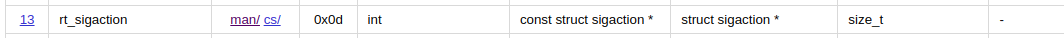

In [ ]:
#include <signal.h>
int sigaction (int signo,
 const struct sigaction *act,
 struct sigaction *oldact);

Вызов функции sigaction() изменяет поведение сигнала, обозначенного аргументом signo. Этот аргумент может принимать любые значения, кроме тех, что ассоциируются с SIGKILL и SIGSTOP.

Если act не равно NULL, то этот системный вызов изменяет актуальное поведение сигнала так, как это указано в act. 

Структура sigaction определяется следующим образом:


In [ ]:
struct sigaction {
 void (*sa_handler)(int); /* обработчик сигнала или действие */
 void (*sa_sigaction)(int, siginfo_t *, void *);
 sigset_t sa_mask; /* сигналы, которые следует блокировать */
 int sa_flags; /* флаги */
 void (*sa_restorer)(void); /* устаревшее поле, не соответствует POSIX */
};

sa_handler указывает действие, которое будет связано с signo и может быть одним из следующих:

- SIG_DFL (0) для действия по умолчанию.

- SIG_IGN (1) для игнорирования этого сигнала.

- Указатель на функцию обработки сигнала. Эта функция получает номер сигнала в качестве единственного аргумента. Эта функция имеет следующий прототип: void my_handler (int signo).

Если флаг SA_SIGINFO установлен в поле sa_flags, то именно поле sa_sigaction, а не sa_handler определяет ту функцию, которая будет обрабатывать сигнал. Прототип этой функции немного отличается от предыдущего:

void my_handler (int signo, siginfo_t *si, void *ucontext);

Эта функция получает номер сигнала в качестве своего первого параметра, структуру siginfo_t — в качестве второго и структуру ucontext_t (приведенную к указателю void) — в качестве третьего параметра. Она не имеет возвращаемого значения.

В поле sa_mask предоставляется набор сигналов, которые система должна блокировать на протяжении выполнения обработчика сигнала. 

Таким образом, программист может самостоятельно налагать нужную защиту от повторного входа сразу для многих обработчиков сигналов. Сигнал, обрабатываемый в текущий момент, также блокируется, если в поле sa_flags не установлен флаг SA_NODEFER. Вы не можете блокировать SIGKILL или SIGSTOP. Вызов будет бесшумно игнорировать любой из них в sa_mask.

Поле sa_flags — это битовая ИЛИ маска, включающая нуль, один или несколько флагов, изменяющих обработку сигнала, указанного как signo. В поле sa_flags также могут находиться следующие значения:

- SA_NOCLDSTOP — если signo соответствует сигнал SIGCHLD, этот флаг приказывает системе не выдавать уведомления, когда дочерний процесс останавливает или возобновляет работу.
- SA_NOCLDWAIT — если signo соответствует сигнал SIGCHLD, этот флаг обеспечивает автоматическое снятие дочерних процессов: при завершении дочерние процессы не превращаются в зомби, а родителю не приходится вызывать для них wait() (более того, он и не может этого сделать). 
- SA_NOMASK — этот флаг является устаревшим эквивалентом SA_NODEFER, не поддерживаемым в POSIX. Вместо SA_NOMASK используйте SA_NODEFER - не добавляет сигнал в маску сигнала потока, пока обработчик выполняется, если сигнал не указан в sa_mask. 
- SA_ONESHOT — этот флаг является устаревшим эквивалентом SA_RESETHAND, не поддерживаемым в POSIX.
- SA_ONSTACK — этот флаг приказывает системе вызвать указанный обработчик сигналов для альтернативного сигнального стека, предоставляемого функцией sigaltstack(). Если вы не предоставите альтернативный стек, то будет использоваться стек, заданный по умолчанию. Соответственно, система будет действовать так, словно этот флаг вообще отсутствует. Альтернативные сигнальные стеки встречаются редко, хотя они и полезны в некоторых Pthreads-приложениях с небольшими стеками потоков, которые могут переполняться в результате определенных действий обработчика сигналов.
- SA_RESTART — этот флаг обеспечивает перезапуск в стиле BSD для тех системных вызовов, выполнение которых было прервано сигналами.
- SA_RESETHAND — сигнал активизирует «одноразовый» режим. Как только возвращается обработчик сигнала, поведение сигнала, снабженного этим флагом, сбрасывается на заданное по умолчанию.
- SA_SIGINFO (начиная с Linux 2.2)  Обработчик сигнала принимает три аргумента, а не один.

Соответствие названиям флагов их числовых значений определяется в sygnal.h.

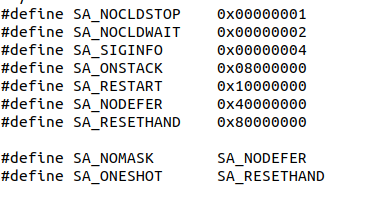

В случае успеха вызов sigaction() возвращает 0. При ошибке вызов возвращает -1.

Структура siginfo_t также определяется в <sys/signal.h> следующим образом:

In [ ]:
typedef struct siginfo_t {
 int si_signo; /* номер сигнала */
 int si_errno; /* значение errno */
 int si_code; /* код сигнала */
 pid_t si_pid; /* идентификатор pid отсылающего процесса */
 uid_t si_uid; /* реальный идентификатор uid отсылающего процесса */
 int si_status; /* значение выхода или сигнал */
 clock_t si_utime; /* затраченное пользовательское время */
 clock_t si_stime; /* затраченное системное время */
 sigval_t si_value; /* значение полезной нагрузки сигнала */
 int si_int; /* сигнал POSIX.1b */
 void *si_ptr; /* сигнал POSIX.1b */
 void *si_addr; /* местоположение в памяти, спровоцировавшее ошибку */
 int si_band; /* событие полосы */
 int si_fd; /* дескриптор файла */
};

Системный вызов **kill()**, лежащий в основе распространенной утилиты kill, отправляет сигнал от одного процесса к другому:


In [ ]:
#include <sys/types.h>
#include <signal.h>
int kill (pid_t pid, int signo);

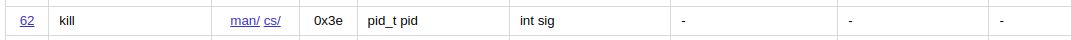

В обычной ситуации (когда pid больше нуля) kill() посылает сигнал signo процессу с идентификатором pid.

Если параметр pid равен нулю, signo отправляется всем процессам, относящимся к той же группе, что и вызывающий процесс.

Если pid равен -1, то сигнал signo отсылается всем тем процессам, которым вызывающий процесс может отправить сигнал (имеет на это право доступа), за исключением init и себя самого. 

В случае успеха kill() возвращает 0. Вызов считается успешным, как только удастся послать один сигнал. При ошибке (ни один сигнал послать не удалось) вызов возвращает -1.

Для того чтобы отправить сигнал другому процессу, отсылающий процесс должен располагать соответствующими правами доступа. Процесс от имени администратора может послать сигнал любому процессу. Обычный процесс может послать сигнал, только если  ID процесса-отправителя равен реальному или сохраненному пользовательскому ID процесса-получателя. Проще говоря, обычный пользователь может послать сигнал лишь такому процессу, каким владеет сам. В UNIX-системах и в Linux в частности определяется исключение для SIGCONT: процесс может послать этот сигнал любому процессу из того же сеанса. Совпадения пользовательского ID не требуется.

Ниже представлена небольшая программа, демонстрирующая использование вызова kill:

- программа получает на вход PID процесса
- останавливает этот процесс на заданное время, посылая сигнал Stop
- продолжает процесс на некоторое время, посылая сигнал Cont
- повторяет предыдущие два действия по кругу.

In [ ]:
	;; kill_stop.asm
	
	format elf64

	public _start

	extrn printf
	extrn getchar
	extrn usleep

	include "func.asm"
	
	section '.data' writable
	
	msg_1 db "stop", 0xa, 0
	
	msg_2 db "cont", 0xa, 0

	section '.bss' writable
	
	pid dq 1
	


	section '.text' executable
	
_start:



        mov rsi, [rsp+16]
	call str_number
	mov [pid], rax
.loop:
	mov rdi, msg_2
	call printf
	
	mov rdi, 3000000
	call usleep
	
	mov rdi, [pid]
	mov rsi, 19
	mov rax, 62
	syscall
	
	mov rdi, msg_1
	call printf
	
	mov rdi, 3000000
	call usleep
	
	mov rdi, [pid]
	mov rsi, 18
	mov rax, 62
	syscall
	
jmp .loop
	
	call exit